# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 1671168/11490434 [===>..........................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:42 - loss: 0.6935

  23/1875 [..............................] - ETA: 4s - loss: 0.5723   

  48/1875 [..............................] - ETA: 3s - loss: 0.4866

  72/1875 [>.............................] - ETA: 3s - loss: 0.4428

  94/1875 [>.............................] - ETA: 3s - loss: 0.4164

 119/1875 [>.............................] - ETA: 3s - loss: 0.3948

 147/1875 [=>............................] - ETA: 3s - loss: 0.3766

 176/1875 [=>............................] - ETA: 3s - loss: 0.3618

 206/1875 [==>...........................] - ETA: 3s - loss: 0.3492

 237/1875 [==>...........................] - ETA: 3s - loss: 0.3382

 269/1875 [===>..........................] - ETA: 3s - loss: 0.3285

 301/1875 [===>..........................] - ETA: 2s - loss: 0.3200

 329/1875 [====>.........................] - ETA: 2s - loss: 0.3134

 360/1875 [====>.........................] - ETA: 2s - loss: 0.3067

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3018

 410/1875 [=====>........................] - ETA: 2s - loss: 0.2973

 441/1875 [======>.......................] - ETA: 2s - loss: 0.2921

 464/1875 [======>.......................] - ETA: 2s - loss: 0.2885

 496/1875 [======>.......................] - ETA: 2s - loss: 0.2838

 526/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2765

 570/1875 [========>.....................] - ETA: 2s - loss: 0.2743

 596/1875 [========>.....................] - ETA: 2s - loss: 0.2713

 625/1875 [=========>....................] - ETA: 2s - loss: 0.2681

 652/1875 [=========>....................] - ETA: 2s - loss: 0.2653

 675/1875 [=========>....................] - ETA: 2s - loss: 0.2630

 699/1875 [==========>...................] - ETA: 2s - loss: 0.2607

 730/1875 [==========>...................] - ETA: 2s - loss: 0.2579

 759/1875 [===========>..................] - ETA: 2s - loss: 0.2554

 789/1875 [===========>..................] - ETA: 2s - loss: 0.2530

 811/1875 [===========>..................] - ETA: 2s - loss: 0.2512

 835/1875 [============>.................] - ETA: 1s - loss: 0.2494

 862/1875 [============>.................] - ETA: 1s - loss: 0.2474

 890/1875 [=============>................] - ETA: 1s - loss: 0.2454

 914/1875 [=============>................] - ETA: 1s - loss: 0.2437

 941/1875 [==============>...............] - ETA: 1s - loss: 0.2419

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 995/1875 [==============>...............] - ETA: 1s - loss: 0.2385

1022/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1051/1875 [===============>..............] - ETA: 1s - loss: 0.2352

1077/1875 [================>.............] - ETA: 1s - loss: 0.2337

1103/1875 [================>.............] - ETA: 1s - loss: 0.2323

1133/1875 [=================>............] - ETA: 1s - loss: 0.2307

1164/1875 [=================>............] - ETA: 1s - loss: 0.2291

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2277

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2262

1254/1875 [===================>..........] - ETA: 1s - loss: 0.2248

1279/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1311/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1328/1875 [====================>.........] - ETA: 1s - loss: 0.2215

1355/1875 [====================>.........] - ETA: 0s - loss: 0.2203

1380/1875 [=====================>........] - ETA: 0s - loss: 0.2193

1404/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1472/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1497/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1539/1875 [=======================>......] - ETA: 0s - loss: 0.2132

1561/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1586/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1608/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1628/1875 [=========================>....] - ETA: 0s - loss: 0.2101

1649/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1699/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1723/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1782/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1802/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1823/1875 [============================>.] - ETA: 0s - loss: 0.2040

1845/1875 [============================>.] - ETA: 0s - loss: 0.2033

1870/1875 [============================>.] - ETA: 0s - loss: 0.2026

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 8s - loss: 0.1123

  23/1875 [..............................] - ETA: 4s - loss: 0.1111

  47/1875 [..............................] - ETA: 4s - loss: 0.1110

  70/1875 [>.............................] - ETA: 4s - loss: 0.1107

  96/1875 [>.............................] - ETA: 3s - loss: 0.1104

 121/1875 [>.............................] - ETA: 3s - loss: 0.1102

 144/1875 [=>............................] - ETA: 3s - loss: 0.1100

 170/1875 [=>............................] - ETA: 3s - loss: 0.1098

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 220/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 243/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 268/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 293/1875 [===>..........................] - ETA: 3s - loss: 0.1094

 318/1875 [====>.........................] - ETA: 3s - loss: 0.1093

 343/1875 [====>.........................] - ETA: 3s - loss: 0.1093

 368/1875 [====>.........................] - ETA: 3s - loss: 0.1092

 394/1875 [=====>........................] - ETA: 3s - loss: 0.1091

 420/1875 [=====>........................] - ETA: 3s - loss: 0.1090

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 472/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 497/1875 [======>.......................] - ETA: 2s - loss: 0.1088

 522/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 547/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 572/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 597/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 622/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 646/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 671/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 695/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 718/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 739/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 759/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 784/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 806/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 831/1875 [============>.................] - ETA: 2s - loss: 0.1080

 856/1875 [============>.................] - ETA: 2s - loss: 0.1080

 874/1875 [============>.................] - ETA: 2s - loss: 0.1079

 895/1875 [=============>................] - ETA: 2s - loss: 0.1079

 915/1875 [=============>................] - ETA: 2s - loss: 0.1078

 938/1875 [==============>...............] - ETA: 2s - loss: 0.1078

 958/1875 [==============>...............] - ETA: 1s - loss: 0.1077

 972/1875 [==============>...............] - ETA: 1s - loss: 0.1077

 993/1875 [==============>...............] - ETA: 1s - loss: 0.1077

1013/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1060/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1084/1875 [================>.............] - ETA: 1s - loss: 0.1075

1104/1875 [================>.............] - ETA: 1s - loss: 0.1074

1127/1875 [=================>............] - ETA: 1s - loss: 0.1074

1148/1875 [=================>............] - ETA: 1s - loss: 0.1073

1168/1875 [=================>............] - ETA: 1s - loss: 0.1073

1191/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1214/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1265/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1287/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1311/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1337/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1362/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1382/1875 [=====================>........] - ETA: 1s - loss: 0.1069

1408/1875 [=====================>........] - ETA: 1s - loss: 0.1068

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1456/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1481/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1506/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1533/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1553/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1578/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1601/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1620/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1646/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1672/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1697/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1749/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1775/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1801/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1827/1875 [============================>.] - ETA: 0s - loss: 0.1061

1854/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1003

  27/1875 [..............................] - ETA: 3s - loss: 0.0994

  54/1875 [..............................] - ETA: 3s - loss: 0.0988

  80/1875 [>.............................] - ETA: 3s - loss: 0.0986

 106/1875 [>.............................] - ETA: 3s - loss: 0.0985

 132/1875 [=>............................] - ETA: 3s - loss: 0.0984

 158/1875 [=>............................] - ETA: 3s - loss: 0.0983

 184/1875 [=>............................] - ETA: 3s - loss: 0.0983

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0983

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0983

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0982

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0982

 309/1875 [===>..........................] - ETA: 3s - loss: 0.0982

 334/1875 [====>.........................] - ETA: 3s - loss: 0.0982

 359/1875 [====>.........................] - ETA: 3s - loss: 0.0982

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 646/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 772/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 823/1875 [============>.................] - ETA: 2s - loss: 0.0982

 848/1875 [============>.................] - ETA: 2s - loss: 0.0982

 869/1875 [============>.................] - ETA: 2s - loss: 0.0982

 893/1875 [=============>................] - ETA: 2s - loss: 0.0982

 918/1875 [=============>................] - ETA: 1s - loss: 0.0982

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1085/1875 [================>.............] - ETA: 1s - loss: 0.0981

1110/1875 [================>.............] - ETA: 1s - loss: 0.0981

1135/1875 [=================>............] - ETA: 1s - loss: 0.0981

1159/1875 [=================>............] - ETA: 1s - loss: 0.0981

1184/1875 [=================>............] - ETA: 1s - loss: 0.0981

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1831/1875 [============================>.] - ETA: 0s - loss: 0.0979

1857/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0948

  25/1875 [..............................] - ETA: 3s - loss: 0.0987

  51/1875 [..............................] - ETA: 3s - loss: 0.0980

  76/1875 [>.............................] - ETA: 3s - loss: 0.0975

 101/1875 [>.............................] - ETA: 3s - loss: 0.0972

 127/1875 [=>............................] - ETA: 3s - loss: 0.0970

 153/1875 [=>............................] - ETA: 3s - loss: 0.0969

 180/1875 [=>............................] - ETA: 3s - loss: 0.0968

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0967

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0966

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 285/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 311/1875 [===>..........................] - ETA: 3s - loss: 0.0964

 335/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 360/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 387/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 807/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 831/1875 [============>.................] - ETA: 2s - loss: 0.0962

 857/1875 [============>.................] - ETA: 2s - loss: 0.0962

 882/1875 [=============>................] - ETA: 2s - loss: 0.0962

 908/1875 [=============>................] - ETA: 1s - loss: 0.0962

 934/1875 [=============>................] - ETA: 1s - loss: 0.0962

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1083/1875 [================>.............] - ETA: 1s - loss: 0.0961

1108/1875 [================>.............] - ETA: 1s - loss: 0.0961

1131/1875 [=================>............] - ETA: 1s - loss: 0.0961

1156/1875 [=================>............] - ETA: 1s - loss: 0.0961

1182/1875 [=================>............] - ETA: 1s - loss: 0.0961

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1829/1875 [============================>.] - ETA: 0s - loss: 0.0960

1853/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0959

  28/1875 [..............................] - ETA: 3s - loss: 0.0957

  55/1875 [..............................] - ETA: 3s - loss: 0.0956

  81/1875 [>.............................] - ETA: 3s - loss: 0.0957

 107/1875 [>.............................] - ETA: 3s - loss: 0.0956

 134/1875 [=>............................] - ETA: 3s - loss: 0.0954

 161/1875 [=>............................] - ETA: 3s - loss: 0.0953

 187/1875 [=>............................] - ETA: 3s - loss: 0.0952

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0952

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 365/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 701/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 749/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 802/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 829/1875 [============>.................] - ETA: 2s - loss: 0.0953

 856/1875 [============>.................] - ETA: 2s - loss: 0.0953

 883/1875 [=============>................] - ETA: 1s - loss: 0.0953

 909/1875 [=============>................] - ETA: 1s - loss: 0.0953

 935/1875 [=============>................] - ETA: 1s - loss: 0.0953

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1088/1875 [================>.............] - ETA: 1s - loss: 0.0953

1115/1875 [================>.............] - ETA: 1s - loss: 0.0953

1140/1875 [=================>............] - ETA: 1s - loss: 0.0953

1161/1875 [=================>............] - ETA: 1s - loss: 0.0953

1186/1875 [=================>............] - ETA: 1s - loss: 0.0953

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1833/1875 [============================>.] - ETA: 0s - loss: 0.0953

1858/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

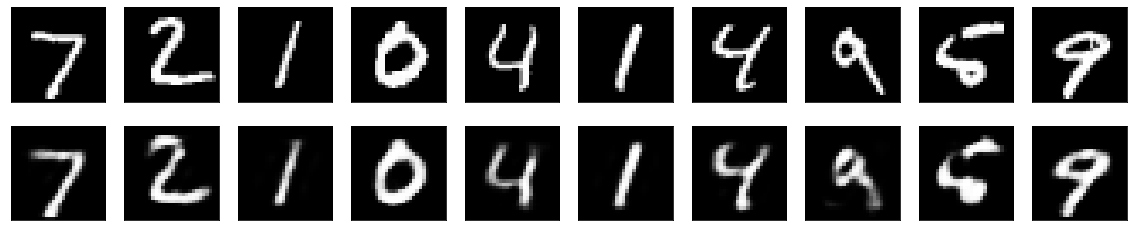

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
